In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import LSTM, Input, Bidirectional,Embedding
from keras.layers import Dense, Activation, Dropout

from tensorflow import keras
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt

In [ ]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt' , 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1130496/1115394 [==============================] - 0s 0us/step


In [ ]:
text = open(path_to_file , 'rb').read().decode( encoding='utf-8' )

print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [ ]:
print(text[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [ ]:
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


In [ ]:
ids_from_chars = preprocessing.StringLookup(vocabulary = list(vocab),
                                            mask_token=None)

In [ ]:
chars_from_ids = tf.keras.layers.experimental.preprocessing.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None
)

In [ ]:
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

In [ ]:
all_ids = ids_from_chars(tf.strings.unicode_split(text , 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [ ]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [ ]:
for ids in ids_dataset.take(10):
  print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [ ]:
seq_length = 50
examples_per_epoch = len(text)//(seq_length+1)

In [ ]:
sequences = ids_dataset.batch(seq_length+1 , drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' '], shape=(51,), dtype=string)


In [ ]:
def split_input_target(sequence):
  input_text = sequence[:-1]
  target_text = sequence[1:]
  return input_text , target_text

In [ ]:
dataset = sequences.map(split_input_target)

In [ ]:
for input_example , target_example in dataset.take(1):
  print('Input: ',text_from_ids(input_example).numpy())
  print('Target: ',text_from_ids(target_example).numpy())

Input:  b'First Citizen:\nBefore we proceed any further, hear'
Target:  b'irst Citizen:\nBefore we proceed any further, hear '


In [ ]:
batch_size = 64

buffer_size = 10000

dataset = (
    dataset
    .shuffle(buffer_size)
    .batch(batch_size,drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [ ]:
vocab_size = len(vocab)

embedding_dim = 256

rnn_units = 1024

In [ ]:
def loss_plot(history):
  plt.xlabel("Number of Epochs")
  plt.ylabel('Loss', fontsize=16)
  plt.plot(history.history['loss'], color='b', label='Training Loss')
  plt.legend(loc='upper right')
  plt.show()

# RNN

In [ ]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.SimpleRNN(rnn_units,
                                   activation='tanh',
                                   return_sequences=True,
                                   return_state=True
                                   )
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x,states
    else:
      return x

In [ ]:
rnn_model = MyModel(
    vocab_size = len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units
)

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
  example_batch_preds = rnn_model(input_example_batch)
  print(example_batch_preds.shape, '#(batch_size, sequence_length, vocab_size)')

(64, 50, 66) #(batch_size, sequence_length, vocab_size)


In [ ]:
rnn_model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  16896     
_________________________________________________________________
simple_rnn (SimpleRNN)       multiple                  1311744   
_________________________________________________________________
dense (Dense)                multiple                  67650     
Total params: 1,396,290
Trainable params: 1,396,290
Non-trainable params: 0
_________________________________________________________________


In [ ]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
opt = keras.optimizers.Adam()
rnn_model.compile(optimizer=opt, loss=loss)

In [ ]:
checkpoint_dir = './training_checkpoints_rnn'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True,
    save_freq = 50)

In [ ]:
epochs = 200

In [ ]:
early_stopping = EarlyStopping(monitor = 'loss', patience = 10, mode = 'min', verbose=2)
reduce_lr =  ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=5, min_lr=0.000001, verbose=2)
history_rnn = rnn_model.fit(dataset, epochs=epochs, callbacks=[early_stopping, reduce_lr, checkpoint_callback])

Epoch 1/200
341/341 [==============================] - 28s 76ms/step - loss: 2.5294
Epoch 2/200
341/341 [==============================] - 26s 75ms/step - loss: 1.9476
Epoch 3/200
341/341 [==============================] - 27s 76ms/step - loss: 1.7391
Epoch 4/200
341/341 [==============================] - 27s 76ms/step - loss: 1.6216
Epoch 5/200
341/341 [==============================] - 27s 76ms/step - loss: 1.5515
Epoch 6/200
341/341 [==============================] - 26s 75ms/step - loss: 1.5015
Epoch 7/200
341/341 [==============================] - 27s 76ms/step - loss: 1.4663
Epoch 8/200
341/341 [==============================] - 27s 76ms/step - loss: 1.4386
Epoch 9/200
341/341 [==============================] - 27s 76ms/step - loss: 1.4139
Epoch 10/200
341/341 [==============================] - 27s 76ms/step - loss: 1.3952
Epoch 11/200
341/341 [==============================] - 27s 76ms/step - loss: 1.3771
Epoch 12/200
341/341 [==============================] - 26s 75ms/step - lo

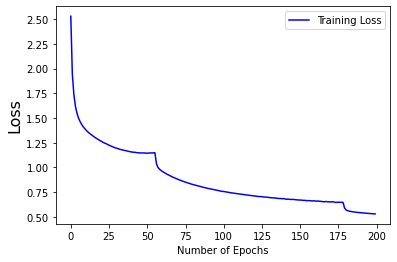

In [ ]:
loss_plot(history_rnn)

In [ ]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    predicted_logits = predicted_logits + self.prediction_mask

    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    predicted_chars = self.chars_from_ids(predicted_ids)

    return predicted_chars, states

In [ ]:
one_step_model = OneStep(rnn_model, chars_from_ids, ids_from_chars)

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

Romeo?

MERCUTIO:
My lords
are at the place,--

MENENIUS:
O my liege,
Heart love aurable and by himself.

WARWICK:
And thou at their country are o' the people.

Pursuivant:
I thought your name is Duke of Norfolk lenity
to prepare myself.

Nurse:
Marry, I'll report it, adieu; and most desires my uncle Retemosing.

SICINIUS:
'Twas no thing, I say the price o' the sly government,
Yet laugh at time right.

LEONTES:
How! can yield me not, my lord, and you mistakes discreetly hates of pity.
The Lords
not to me this shall proceed
For thy head by his head to prepare my friends as that with his grace,
To catch my duty!

Second Keeper:
Besides, you
A strange fit to do,
By lack of love and roteer.
A wickion too, for this night.

PETRUCHIO:
Why, hence!

AUFIDIUS:
Go tell thee:
He that both of your office that's gone.

Clown:
We are inform'd the stuff,
From which I dourt-port with Proteanue; for thou hast been!

ANGELO:
What store were they shall compell'd
As to your mother
That white Richard reign

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b"Romeo\nTo take order we saw now, this land will happy foolery,\nBeing one craves a near\nThat runagate guest: here is here unto this kern'd?\nWhat is the provost? What, marvel, spend thee to the city.\nIs cries King Edward Edward Plainnal tears,\nAnd love thee o'er in smiles of quality\nHis ars. Come, let's be;\nAnd must go with me for Rome again after a great deal to tell it not.\n\nSecond Senator:\nCurse of remorse; his name remain\nA dozen out of.\n\nELBOW:\nAy, sir; I have\nThe prince I came\nTo liberty.\nUnless for my own,--as the queen through these woes,\nAnd am I sent for\nthis good with a wealth\nShould be county is grown but Henry is the bastard.\n\nBIANCA:\nThat 'dive, it must needs be dine;\nHave chip my father well.\n\nLUCIO:\nHe was dream i' the commons which is another fellow'd all this,\nI have some more from Green, some other side more.\nFor what he, to our gentlemen,\nTherefore yet hath set his shriving: why stand up:'l dishonour, in good hope to worn nu

# GRU

In [ ]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   activation='tanh',
                                   return_sequences=True,
                                   return_state=True
                                   )
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x,states
    else:
      return x

In [ ]:
gru_model = MyModel(
    vocab_size = len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units
)

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
  example_batch_preds = gru_model(input_example_batch)
  print(example_batch_preds.shape, '#(batch_size, sequence_length, vocab_size)')

(64, 50, 66) #(batch_size, sequence_length, vocab_size)


In [ ]:
gru_model.summary()

Model: "my_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  16896     
_________________________________________________________________
gru (GRU)                    multiple                  3938304   
_________________________________________________________________
dense_1 (Dense)              multiple                  67650     
Total params: 4,022,850
Trainable params: 4,022,850
Non-trainable params: 0
_________________________________________________________________


In [ ]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
opt = keras.optimizers.RMSprop(learning_rate=1e-3)
gru_model.compile(optimizer=opt, loss=loss)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True,
    save_freq = 50)

In [ ]:
epochs = 200

In [ ]:
early_stopping = EarlyStopping(monitor = 'loss', min_delta=0.001, patience = 10, mode = 'min', verbose=2)
reduce_lr =  ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=5, min_lr=0.000001, verbose=2)
history_gru = gru_model.fit(dataset, epochs=epochs, callbacks=[early_stopping, reduce_lr, checkpoint_callback])

Epoch 1/200
341/341 [==============================] - 27s 72ms/step - loss: 2.2346
Epoch 2/200
341/341 [==============================] - 25s 72ms/step - loss: 1.6333
Epoch 3/200
341/341 [==============================] - 25s 72ms/step - loss: 1.4683
Epoch 4/200
341/341 [==============================] - 25s 72ms/step - loss: 1.3819
Epoch 5/200
341/341 [==============================] - 25s 72ms/step - loss: 1.3191
Epoch 6/200
341/341 [==============================] - 25s 72ms/step - loss: 1.2660
Epoch 7/200
341/341 [==============================] - 25s 72ms/step - loss: 1.2144
Epoch 8/200
341/341 [==============================] - 25s 72ms/step - loss: 1.1630
Epoch 9/200
341/341 [==============================] - 25s 72ms/step - loss: 1.1101
Epoch 10/200
341/341 [==============================] - 25s 71ms/step - loss: 1.0554
Epoch 11/200
341/341 [==============================] - 25s 71ms/step - loss: 0.9998
Epoch 12/200
341/341 [==============================] - 25s 71ms/step - lo

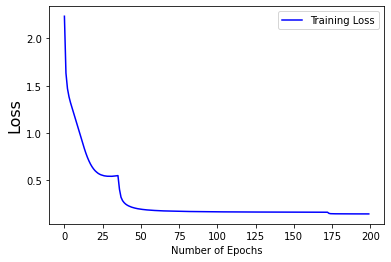

In [ ]:
loss_plot(history_gru)

In [ ]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(

        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):

    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    predicted_logits = predicted_logits + self.prediction_mask

    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    predicted_chars = self.chars_from_ids(predicted_ids)

    return predicted_chars, states

In [ ]:
one_step_model = OneStep(gru_model, chars_from_ids, ids_from_chars)

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

Romeo
To comfort you: I wot well where he is.
Hark you, sir, be gone, conduit that the absent duke.

LUCIO:
A very superficial, ignorant, any thing, my gracious lord.

QUEEN ELIZABETH:
Nay, then his good hearts and think some would have deadly shape.

LEONTES:
By my head with such mind he bear me: I hope, and will
Prithee now, sweet father, dissal time, and snaples;
Where were her life? she durst not call me.'

Third Citizen:
Nurse, come hither, master and my father?

POMPEY:
They shall stir a virtuous strength constant me.
I hope the king miscarried him where he is
aboard, tender your intercepantion hablest from the facation
A poor and brook itted story of the feast,
And not our tenret till away him speak for the other senses. I cannot fly.

Ahe heaven with those that should have laid our friends, ready in your commony.

CAMILLO:
I am afray: but hear me.
Your breast for fair cousin Hereford and the fear
Would sleep that women are so storm, else, when a country, as those colours
Not pa

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b"Romeo,\nWho had but newly entertain'd revenge,\nAnd the subjects to infringed visits,\nHe till the end of the horses; in the consecrate of his troop's deep,\nThat bad tirtGor Jamy of the same I may condect what we in placeed.\nLord, what says he of our friendshorped.\nWhere is my lady widow sister?\n\nPETRUCHIO:\nWhat, shall this speech be Clifford, in Were well.\nThere is the womb for wronged woe.\n\nGREMIO:\nBeloved mortality, that thou canst undernearth.\n\nQUEEN MARGARET:\nRichard!\n\nEDWARD:\nLet Geppoot that raison rags and treasure prove as he\npies in God's name, shall to this prayers; for one things loved\nWhich made you go to the crown and only clap their backs.\nShe hap of revolter, father, do more unnatural: soetly men, and where\nIf she hath a power on her to question my misery.\n\nGLOUCESTER:\nThe widow dainty Menenur, come on; where is your boar-sceneth is to be said,\nAs thou hast any crazery true dead.\n\nJULIET:\nWhat men devil, fain delight,\nWherein th

In [ ]:
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')

In [ ]:
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(100):
  next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
  result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

Romeo:
'Tis thought your heart is full of woman: shall I lead a shows
Be rashold as my master slew my brot
